In [1]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data
import torchvision
from torchvision import datasets, transforms
from torchsummary import summary

In [2]:
# Automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import sys

COLAB = 'google.colab' in str(get_ipython())
HAS_GPU = torch.cuda.is_available()
is_local = not COLAB

if COLAB: # running on Colab
    
    from google.colab import drive
    drive.flush_and_unmount()
    
    drive.mount('/content/drive', force_remount=True)
    gdrive_path = '/content/drive//MyDrive/DL4CV-2022/project-I/'
    sys.path.append(gdrive_path)

    zip_path_train = gdrive_path + 'data/Final_Training.zip'
    zip_path_val = gdrive_path + 'data/Final_Validation.zip'
    zip_path_test = gdrive_path + 'data/Final_Test.zip'
    !unzip -q "{zip_path_train}"
    !unzip -q "{zip_path_val}"
    !unzip -q "{zip_path_test}"
    
    if HAS_GPU:
        print("Using GPU")
else:
    HAS_GPU = False
    print("Using CPU")
    
import utils.helpers as utils
#import loader.gtsrb_data as dataset

# If we run cuda then accomodate these datatypes.
FloatTensor = torch.cuda.FloatTensor if HAS_GPU else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if HAS_GPU else torch.LongTensor
ByteTensor = torch.cuda.ByteTensor if HAS_GPU else torch.ByteTensor
Tensor = FloatTensor

Using CPU


In [4]:
if COLAB:
  !ls /content/Final_Training/Images
else:
  !ls data/Final_Training/Images

00000 00004 00008 00012 00016 00020 00024 00028 00032 00036 00040
00001 00005 00009 00013 00017 00021 00025 00029 00033 00037 00041
00002 00006 00010 00014 00018 00022 00026 00030 00034 00038 00042
00003 00007 00011 00015 00019 00023 00027 00031 00035 00039


In [5]:
import loader.args as load_args
args = load_args.get_args(is_local)

TRAIN_DATA_PATH = args.data_dir_train
VAL_DATA_PATH = args.data_dir_val
TEST_DATA_PATH = args.data_dir_test
BATCH_SIZE = args.batch_size
EPOCHS = 10
BATCH_SIZE = args.batch_size
LEARNING_RATE = args.learning_rate

In [6]:
from loader import transforms as tfs
    # NO augmentation--> train=39209, test=12630, val=3870.

train_data = datasets.ImageFolder(
    root=TRAIN_DATA_PATH, 
    transform=tfs.base_transform)
train_loader = data.DataLoader(train_data, 
    batch_size=BATCH_SIZE, shuffle=True,  
    num_workers=2)

val_data = datasets.ImageFolder(
    root=VAL_DATA_PATH, 
    transform=tfs.base_transform)
val_loader  = data.DataLoader(val_data, 
    batch_size=BATCH_SIZE, shuffle=False, 
    num_workers=2)

In [7]:
print()
print('Unaugmented dataset: %d training samples & %d validation samples\n' % (
len(train_loader)*args.batch_size, len(val_loader)*args.batch_size))


Unaugmented dataset: 39250 training samples & 3900 validation samples



In [8]:
args.num_epochs

5

In [9]:
from model.models import Net1

model = Net1()
if HAS_GPU:
    model.cuda()

# Optimizer is updated to *not* include non-gradient weights.    
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                                      lr=args.learning_rate)
# Reduce learning rate when a metric has stopped improving. 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                 patience=5,
                                                 factor=0.5,
                                                 verbose=True)

In [10]:
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]           1,184
         MaxPool2d-2            [-1, 8, 13, 13]               0
              ReLU-3            [-1, 8, 13, 13]               0
            Conv2d-4             [-1, 10, 9, 9]           2,010
         MaxPool2d-5             [-1, 10, 4, 4]               0
              ReLU-6             [-1, 10, 4, 4]               0
            Linear-7                   [-1, 32]           5,152
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 6]             198
           Conv2d-10          [-1, 100, 28, 28]           7,600
      BatchNorm2d-11          [-1, 100, 14, 14]             200
        Dropout2d-12          [-1, 100, 14, 14]               0
           Conv2d-13          [-1, 150, 12, 12]         135,150
      BatchNorm2d-14            [-1, 15

In [11]:
from utils.meter import AvgMeter, calc_accuracy

train_losses = []
train_accuracies = []

def train(epoch):
    print('Epoch {} -------------------------------------------------------->'.format(epoch) )
    print()
    losses = AvgMeter()
    accuracies = AvgMeter()
    model.train()
    correct = 0
    training_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        if HAS_GPU:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        losses.update(loss.item(), data.size(0))
        accuracy = calc_accuracy(output, target)[0]
        train_accuracies.append(int(accuracy))
        accuracies.update(accuracy, data.size(0))
        
        loss.backward()
        optimizer.step()
        max_index = output.max(dim = 1)[1] # _, predicted
        correct += (max_index == target).sum()
        training_loss += loss
        
        if batch_idx % args.log_interval == 0:
            print('Training set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            losses.avg, int(accuracies.sum/100), accuracies.count, accuracies.avg))
    
    return train_accuracies

In [12]:
val_losses = []
val_accuracies = []

def validate(epoch):
    losses = AvgMeter()
    accuracies = AvgMeter()
    error_cases = []
    
    model.eval() # changes the forward() behaviour of the module for val/test.
    
    with torch.no_grad(): # disable tracking of gradients in autograd.
        for data, target in val_loader:
            if HAS_GPU:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            loss = F.nll_loss(output, target)

            losses.update(loss.item(), data.size(0))
            accuracy = calc_accuracy(output, target)[0]
            val_accuracies.append(accuracy)
            accuracies.update(accuracy, data.size(0))

            _, pred = output.topk(1, 1, True, True)
            pred = pred.t()

        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            losses.avg, int(accuracies.sum/100), accuracies.count, accuracies.avg))

    return val_accuracies

In [13]:
import numpy as np
import pandas as pd
import sklearn.metrics as sm

def test(test_loader):
    model.eval()
    correct = 0
    targets, preds = [], []
    
    with torch.no_grad():
        for data, target in test_loader:
            if HAS_GPU:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

            targets += list(target.cpu().numpy())
            preds += list(pred.cpu().numpy())

    test_acc = 100. * correct / len(test_loader.dataset)
    confusion_mtx = sm.confusion_matrix(targets, preds)
    return test_acc, confusion_mtx

In [14]:
training_accuracy = []
validation_accuracy = []

#for epoch in range(1, args.num_epochs + 1):
for epoch in range(1, 1 + 1):
    training_accuracy.append(train(epoch))
    validation_accuracy.append(validate(epoch))

Epoch 1 -------------------------------------------------------->

Training set: Average loss: 3.8708, Accuracy: 2/50 (4.000%)

Training set: Average loss: 3.4279, Accuracy: 1146/10050 (11.403%)

Training set: Average loss: 3.0673, Accuracy: 3988/20050 (19.890%)

Training set: Average loss: 2.7199, Accuracy: 8349/30050 (27.784%)



/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE'
  warn(f"Failed to load image Python extension: {e}")
/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: dlopen(/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_m1/lib/python3.8/site-packages/torchvision/image.so, 0x0006): symbol not found in flat namespace '__ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_1


Validation set: Average loss: 1.5327, Accuracy: 2181/3870 (56.36%)



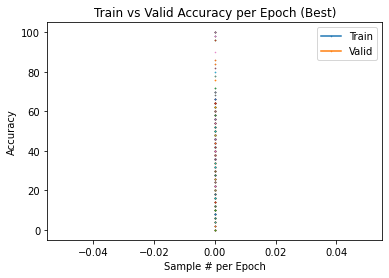

In [15]:
import matplotlib.pyplot as plt

# Plot accuracy

plt.plot(training_accuracy,'-o', markersize=.5)
plt.plot(validation_accuracy,'-o', markersize=.5)
plt.xlabel('Sample # per Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy per Epoch (Best)')
None

In [ ]:
from torch.utils.data import Dataset
from loader.gtsrb_data import GTSRB_Test
from utils.tensor2image import imshow

if COLAB:
    GTSRB_test_dataset = GTSRB_Test('/content/')
    
else:
    GTSRB_test_dataset = GTSRB_Test('data/')

assert len(GTSRB_test_dataset) == 12630

In [ ]:
img, label = GTSRB_test_dataset[7]
imshow(img, label)


In [ ]:
GTSRB_test_dataset.csv_data

In [ ]:
test_loader  = data.DataLoader(GTSRB_test_dataset, 
    batch_size=BATCH_SIZE, shuffle=False, 
    num_workers=2)

In [ ]:
test_accs, confusion_mtxes = [], []

test_acc, confusion_mtx = test(test_loader)
test_accs.append(test_acc)
confusion_mtxes.append(confusion_mtx)

In [ ]:
print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)

In [ ]:
test_acc, confusion_mtx = test(test_loader)

In [ ]:
test_accs, confusion_mtxes = [], []
test_accs.append(test_acc)
confusion_mtxes.append(confusion_mtx)
print('\rBest test acc = %2.2f%%' % max(test_accs), end='', flush=True)

In [ ]:
import seaborn as sns

In [ ]:
import matplotlib.pyplot as plt
print('Dataset: %d training samples & %d testing samples\n' % (
    len(train_loader.dataset), len(test_loader.dataset)))
 
print('Distribution of classes in dataset:')
fig, ax = plt.subplots()
labels = [label for _, label in train_loader.dataset.imgs]
class_labels, counts = np.unique(labels, return_counts=True)
ax.bar(class_labels, counts)
ax.set_xticks(class_labels)
plt.show()

In [ ]:
from utils.visualize import visual

In [ ]:
visual(test_accs, confusion_mtxes, classe_labels)

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy

plt.plot(training_accuracy,'-o', markersize=.5)
plt.plot(validation_accuracy,'-o', markersize=.5)
plt.xlabel('Sample # per Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy per Epoch (Best)')
None

In [ ]:
train_loader = None
val_loader = None

train_loader = torch.utils.data.DataLoader(
 torch.utils.data.ConcatDataset([datasets.ImageFolder(
                                    TRAIN_DATA_PATH, 
                                    transform=tfs.base_transform),
                               datasets.ImageFolder(
                                    TRAIN_DATA_PATH,
                                    transform=tfs.data_translate),
                               datasets.ImageFolder(
                                    TRAIN_DATA_PATH,
                                    transform=tfs.data_grayscale),
                               datasets.ImageFolder(
                                    TRAIN_DATA_PATH,
                                    transform=tfs.data_center),
                               datasets.ImageFolder(
                                    TRAIN_DATA_PATH,
                                    transform=tfs.data_rotate),
                               datasets.ImageFolder(
                                    TRAIN_DATA_PATH,
                                    transform=tfs.data_jitter_hue)]), 
                                    batch_size=args.batch_size, 
                                    shuffle=True, num_workers=2, 
                                    pin_memory=HAS_GPU)

val_loader = torch.utils.data.DataLoader(
 torch.utils.data.ConcatDataset([datasets.ImageFolder(
                                    VAL_DATA_PATH, 
                                    transform=tfs.base_transform),
                               datasets.ImageFolder(
                                    VAL_DATA_PATH,
                                    transform=tfs.data_translate),
                               datasets.ImageFolder(
                                    VAL_DATA_PATH,
                                    transform=tfs.data_grayscale),
                               datasets.ImageFolder(
                                    VAL_DATA_PATH,
                                    transform=tfs.data_center),
                               datasets.ImageFolder(
                                    VAL_DATA_PATH,
                                    transform=tfs.data_rotate),
                               datasets.ImageFolder(
                                    VAL_DATA_PATH,
                                    transform=tfs.data_jitter_hue)]), 
                                    batch_size=args.batch_size, 
                                    shuffle=False, num_workers=2, 
                                    pin_memory=HAS_GPU)

In [ ]:
print('Augmented dataset: %d training samples & %d validation samples\n' % (
    len(train_loader.dataset), len(val_loader.dataset)))

# Get labels from concatenated datasets.
train_dataset_list = train_loader.dataset.datasets
train_concat_labels = []
for ds in train_dataset_list:
    train_concat_labels.extend(ds.targets)

val_dataset_list = val_loader.dataset.datasets
val_concat_labels = []
for ds in val_dataset_list:
    val_concat_labels.extend(ds.targets)

class_labels = range(43)

print('Distribution of classes in augmented train dataset:')
fig, ax = plt.subplots()
_, counts = np.unique(train_concat_labels, return_counts=True)
ax.bar(class_labels, counts)
ax.set_xticks(class_labels, minor=True)
plt.show()

In [ ]:
model = None

model = Net1()
if HAS_GPU:
    model.cuda()

# Optimizer is updated to *not* include non-gradient weights.    
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                                      lr=args.learning_rate)
# Reduce learning rate when a metric has stopped improving. 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',
                                                 patience=5,
                                                 factor=0.5,
                                                 verbose=True)

In [ ]:
# Reset these
training_accuracy = []
validation_accuracy = []
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Note: Runtime for the following is roughly 8:35.
for epoch in range(1, args.num_epochs + 1):
    training_accuracy.append(train(epoch))
    validation_accuracy.append(validate(epoch))

In [ ]:
# Plot accuracy

plt.plot(training_accuracy[4],'-o', markersize=.5)
plt.plot(validation_accuracy[4],'-o', markersize=.5)
plt.xlabel('Sample # per Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy per Epoch (Best)')
None

In [ ]:
'''
    train_data        = torchvision.datasets.ImageFolder(root=TRAIN_DATA_PATH, 
                                                         transform=tfs.data_transforms)
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
    test_data         = torchvision.datasets.ImageFolder(root=TEST_DATA_PATH, 
                                                         transform=tfs.data_transforms)
    test_loader  = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_data          = torchvision.datasets.ImageFolder(root=VAL_DATA_PATH, 
                                                         transform=tfs.data_transforms)
    val_loader   = data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
    
    
ds = datasets.ImageFolder(VAL_DATA_PATH, transform=None)
#dir(ds)
#ds.samples[0:5] # the first five samples
#ds.imgs[33] # img 33
#ds.samples[33] # sample 33, equivalent of previous line
#ds.samples[33][0] # a sample path
#ds.samples[33][1] # a sample class label
#ds.find_classes(VAL_DATA_PATH)
#ds.targets


def validation():
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
            if HAS_GPU:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
            validation_loss += F.nll_loss(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    scheduler.step(np.around(validation_loss,2))
    
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset))) 
        
        
def train(epoch):
    losses = AvgMeter()
    accuracies = AvgMeter()
    
    model.train()
    correct = 0
    training_loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        if HAS_GPU:
            data = data.cuda()
            target = target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        
        #losses.update(loss.item(), data.size(0))
        #accuracy = calc_accuracy(output, target)[0]
        #accuracies.update(accuracy, data.size(0))
        
        loss.backward()
        optimizer.step()
        max_index = output.max(dim = 1)[1] # _, predicted
        correct += (max_index == target).sum()
        training_loss += loss
        
        if batch_idx % args.log_interval == 0:
            train_loss=training_loss / len(train_loader.dataset)
            accu = 100. * correct / len(train_loader.dataset)
            print('Train Loss: %.3f | Accuracy: %.3f'%(train_loss,accu))
            print('---------------------------------------------------')
            print('Epoch: {} [{}/{} ({:.0f}%)]\tLoss per example: {:.6f}\tLoss: {:.6f}'.format(
                        epoch, 
                        batch_idx * len(data), # this batch number, times total length
                        len(train_loader.dataset), # length of the entire dataset.
                        100. * batch_idx / len(train_loader), 
                        loss.data.item()/(args.batch_size * args.log_interval),
                        loss.data.item()) )
            
    train_accu.append(accu.detach().cpu().numpy())
    train_losses.append(train_loss.detach().cpu().numpy())
    
    
def validation():
    eval_losses=[]
    eval_accu_ls=[]

    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        with torch.no_grad():
            data, target = Variable(data), Variable(target)
            if HAS_GPU:
                data = data.cuda()
                target = target.cuda()
            output = model(data)
             # sum up batch loss
            validation_loss += F.nll_loss(output, 
                                          target, 
                                          size_average=False).data.item()
            # get the index of the max log-probability
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        validation_loss /= len(val_loader.dataset)
        scheduler.step(np.around(validation_loss,2))

        eval_loss=validation_loss / len(val_loader.dataset)
        eval_accu = 100. * correct / len(val_loader.dataset)

    eval_losses.append(eval_loss.detach().cpu().numpy())
    eval_accu_ls.append(eval_accu.detach().cpu().numpy())

    print('Validation Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        validation_loss, 
        correct, 
        len(val_loader.dataset),
        100. * correct / len(val_loader.dataset))
        
        
test_data = datasets.ImageFolder(
    root=TEST_DATA_PATH, 
    transform=tfs.base_transform)
test_loader  = data.DataLoader(test_data, 
    batch_size=BATCH_SIZE, shuffle=True, 
    num_workers=2)

'''